In [176]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
sns.set_context('notebook', font_scale=1.3)
sns.set_style('white'); sns.set_style('white')

In [177]:
EXPERIMENT = 'webofcash-1.4'
tdf = pd.read_pickle(f'data/{EXPERIMENT}/trials.pkl').query('block == "test"')
pdf = pd.read_pickle(f'data/{EXPERIMENT}/participants.pkl')
tdf['click_delay'] = pdf['click_delay'] = pdf.pop('clickDelay').apply(lambda x: str(x/1000)+'s')

tdf['n_click'] = tdf.clicks.apply(len)

for k in ['n_click', 'score']:
    pdf[k] = tdf[k].groupby('wid').mean()

os.makedirs(f'figs/{EXPERIMENT}', exist_ok=True)
def savefig(name, tight=True):
    if tight:
        plt.tight_layout()
    plt.savefig(f'figs/{EXPERIMENT}/{name}.png', dpi=400)

## Payment

Text(0.5, 1.0, 'Median time: 15.03 minutes')

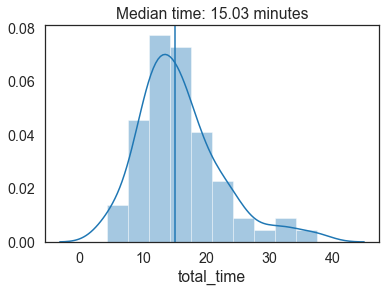

In [62]:
pdf['total_time'] = (pdf.time_end - pdf.time_start) / 1000 / 60
sns.distplot(pdf.total_time)
m = total_time.median()
plt.axvline(m)
plt.title(f'Median time: {m:.2f} minutes')

In [41]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [45]:
rdf = tdf[['trial_index', 'score']].copy()
rdf.trial_index -= rdf.trial_index.min()

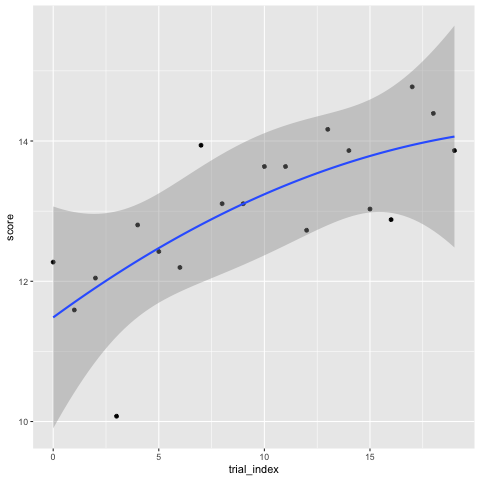

In [57]:
%%R -i rdf
library(ggplot2)
ggplot(rdf, aes(x=trial_index, y=score)) + 
#     geom_point() + 
    stat_summary(fun.y = "mean", geom = "point") +
    geom_smooth(method='lm', formula = y ~ x + I(x^2))

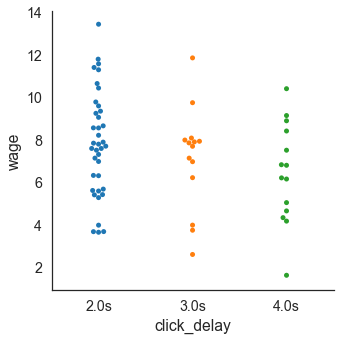

In [36]:
pdf['wage'] = wage
sns.catplot('click_delay', 'wage', data=pdf, kind='swarm')
# sns.catplot('click_delay', 'total_time', data=pdf, kind='point')

Text(0.5, 1.0, 'Median wage: 8.70 $/hr')

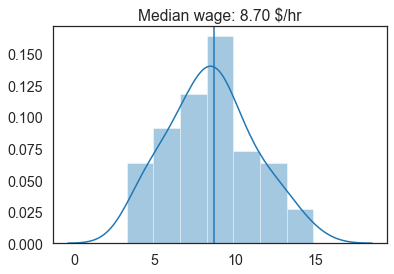

In [64]:
bonus = pdf.final_bonus
wage = 60 * (bonus + 0.5) / total_time
sns.distplot(wage)
m = wage.median()
plt.axvline(m)
plt.title(f'Median wage: {m:.2f} $/hr')

## Pareto

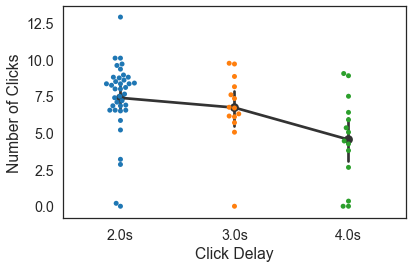

In [178]:
sns.pointplot('click_delay', 'n_click', data=pdf, color='#333333')
sns.swarmplot('click_delay', 'n_click', data=pdf)
plt.xlabel('Click Delay')
plt.ylabel('Number of Clicks')
savefig('click_delay')

Text(0.5, 0, 'Number of Clicks')

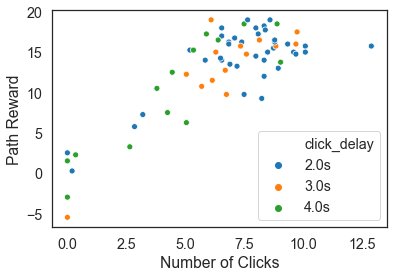

In [179]:
# plt.errorbar(g[x].mean(), g[y].mean(), yerr=g[y].sem(), xerr=g[x].sem(), fmt='none', color='black', elinewidth=.5)
sns.scatterplot('n_click', 'score', hue='click_delay', data=pdf)
plt.ylabel("Path Reward")
plt.xlabel("Number of Clicks")

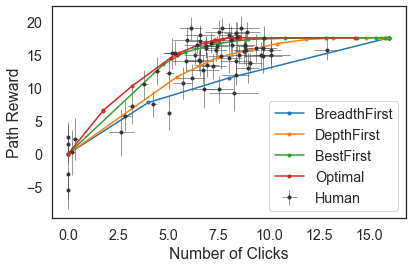

In [181]:
models = 'BreadthFirst DepthFirst BestFirst Optimal'.split()
exp = 'webofcash-1.2'
d1 = pd.read_csv(f"model/results/{exp}/pareto/Optimal.csv")
d1['model'] = 'Optimal'
d2 = pd.read_csv(f"model/results/{exp}/pareto/classical.csv")
model_pareto = pd.concat([d1, d2], sort=False).set_index('model')

def plot_model(model):
    plt.plot('clicks', 'reward', data=model_pareto.loc[model], label=model, marker='.')

g = tdf.groupby('wid'); x = 'n_click'; y = 'score'
plt.errorbar(g[x].mean(), g[y].mean(), yerr=g[y].sem(), xerr=g[x].sem(), 
             label='Human', fmt='.', color='#333333', elinewidth=.5)

for model in models:
    plot_model(model)

# plt.scatter(pdf.n_click, pdf.score, label='Human', color='#333333', marker='x')

plt.ylabel("Path Reward")
plt.xlabel("Number of Clicks")
plt.legend()
savefig('pareto')

In [183]:
m.n_click.max()

14.30272

(0.1, 4)

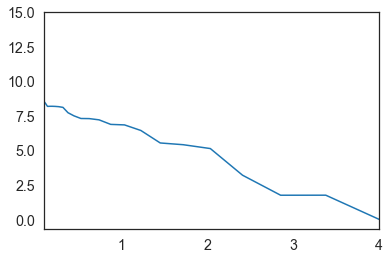

In [188]:
plt.plot(m.cost, m.n_click)
# plt.xscale('log')
plt.xlim(0.1, 4)
# plt.axvline(0.1)
# plt.axvline(4)

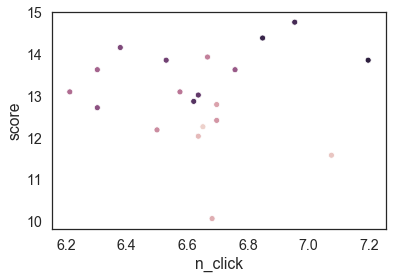

In [113]:
x = tdf.groupby('trial_index')[['score', 'n_click']].mean().reset_index()
sns.scatterplot('n_click', 'score', hue='trial_index', data=x, legend=False)

Text(0, 0.5, 'n_click')

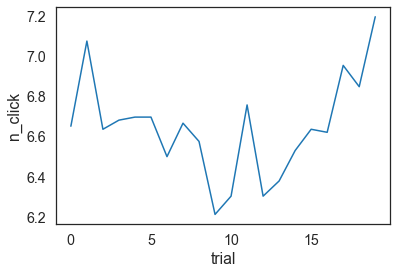

In [149]:
plt.plot(x.n_click)
plt.xlabel('trial')
plt.ylabel('n_click')

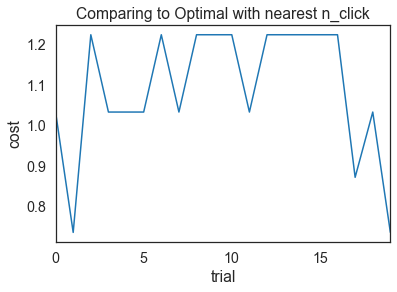

In [157]:
def plot_thing_alt(select):
    def loss(row):
        i = abs(row[select] - m[select]).idxmin()
        return m['cost'][i]
    x.apply(loss, axis=1).plot()
    plt.xlabel('trial')
    plt.ylabel(f'cost')
    plt.title(f'Comparing to Optimal with nearest {select}')
plot_thing_alt('n_click')

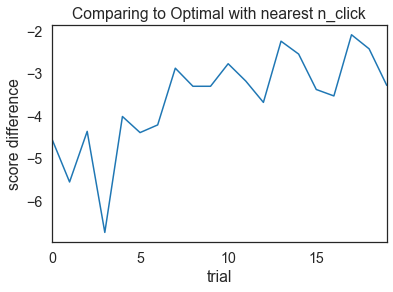

In [151]:
m = model_pareto.query('model == "Optimal"').reset_index()[['clicks', 'reward', 'cost']]
m = m.rename(columns={'clicks': 'n_click', 'reward': 'score'})

def plot_thing(select, y=None):
    if y is None:
        y = next(x for x in ['n_click', 'score'] if x != select)
    def loss(row):
        i = abs(row[select] - m[select]).idxmin()
        return row[y] - m[y][i]
    x.apply(loss, axis=1).plot()
    plt.xlabel('trial')
    plt.ylabel(f'{y} difference')
    plt.title(f'Comparing to Optimal with nearest {select}')

plot_thing('n_click')

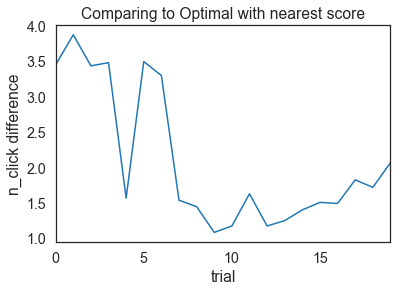

In [146]:
plot_thing('score')

## Parameters

AttributeError: 'PathCollection' object has no property 'hue'

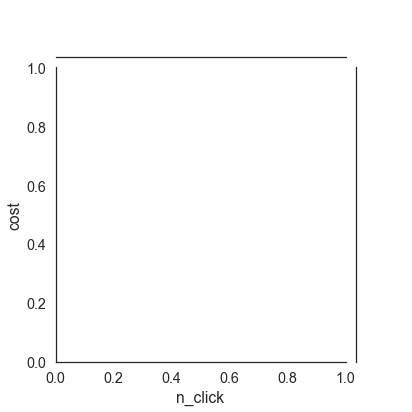

In [35]:
import os
d = pd.read_csv(f'model/results/{EXPERIMENT}/mle/Optimal.csv').set_index('wid')
pdf['cost'] = d.cost.clip(upper=4)
g = sns.jointplot('n_click', 'cost', hue=data=pdf)
plt.sca(g.ax_joint)
plt.xlabel("Number of Clicks")
plt.ylabel("Inferred Cost")
savefig('click_cost_joint')

# Stats

In [54]:
from scipy.stats import mannwhitneyu
cost = df.set_index('condition').cost

def power(x, y, N, sims=1000, alpha=0.05):
    success = np.zeros(sims)
    for i in range(sims):
        u, p = mannwhitneyu(x.sample(N, replace=True), y.sample(N, replace=True))
        success[i] = p < alpha
    return success.mean()
    
power(cost['Icelandic'], cost['Baseline'], 500)

0.124

In [86]:
from scipy.stats import mannwhitneyu
cost = df.query('n_reveal >= 8').set_index('condition').cost

def power(x, y, N, sims=1000, alpha=0.05):
    success = np.zeros(sims)
    for i in range(sims):
        u, p = mannwhitneyu(x.sample(N, replace=True), y.sample(N, replace=True))
        success[i] = p < alpha
    return success.mean()
    
power(cost['Icelandic'], cost['Baseline'], 500)

0.27

In [72]:
cost.Baseline.mean(), cost.Icelandic.mean()

(12.391304347826088, 11.73913043478261)

# Plots

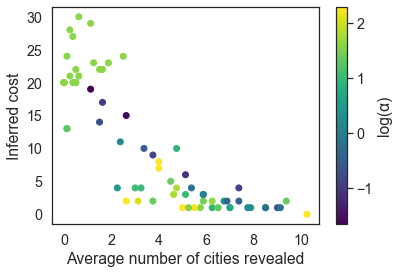

In [9]:
plt.scatter(df.n_reveal/8, df.cost, c=np.log(df.α), cmap='viridis')
plt.xlabel("Average number of cities revealed")
plt.ylabel("Inferred cost")
plt.colorbar(label='log(α)')

In [8]:
df.head()

,icelandic,wid,autocomplete,cost,α,ε,logp,difficulty,mean_rt,n_reveal,condition
0,False,w00fc5e9,False,20.0,5.000500,0.001000,-0.007276,0,NaN,0,Baseline
1,False,w03de12b,True,24.0,5.000500,0.122375,-5.440824,-1,5796.000000,1,Autocomplete
2,True,w04e764c,False,1.0,4.981634,0.497254,-100.268012,1,4319.630435,46,Icelandic
3,True,w0c105b0,False,10.0,0.617647,0.318875,-65.961152,1,6383.729958,27,Icelandic
4,True,w0cfe586,False,4.0,6.230614,0.747717,-81.599899,1,3907.973684,38,Icelandic


Text(55.46783205555556, 0.5, 'Inferred cost')

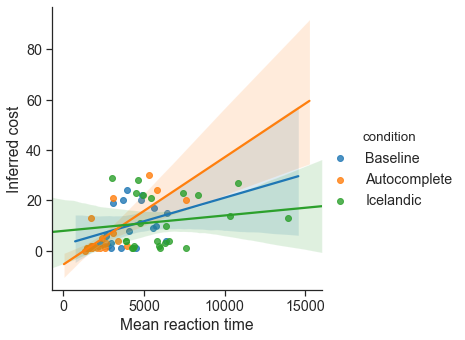

In [15]:
# plt.scatter(df.mean_rt, df.cost, color=df.difficulty)
sns.lmplot('mean_rt', 'cost', hue='condition', data=df, fit_reg=1)
plt.xlabel("Mean reaction time")
plt.ylabel("Inferred cost")
# plt.colorbar(label='log(α)')

In [18]:
def cond_plot(y, exclude=True):
    d = df.query('n_reveal >= 8') if exclude else df
    order=['Autocomplete', 'Baseline', 'Icelandic']
    sns.pointplot('condition', y, data=d,
                 order=order, alpha=0.1)
    sns.swarmplot('condition', y, data=d,
                  order=order, color='black')
    plt.savefig(f'figs/{y}.pdf')

In [28]:
df

,icelandic,wid,autocomplete,cost,α,ε,logp,difficulty,mean_rt,n_reveal,condition
0,False,w00fc5e9,False,20.0,5.000500,0.001000,-0.007276,0,NaN,0,Baseline
1,False,w03de12b,True,24.0,5.000500,0.122375,-5.440824,-1,5796.000000,1,Autocomplete
2,True,w04e764c,False,1.0,4.981634,0.497254,-100.268012,1,4319.630435,46,Icelandic
3,True,w0c105b0,False,10.0,0.617647,0.318875,-65.961152,1,6383.729958,27,Icelandic
4,True,w0cfe586,False,4.0,6.230614,0.747717,-81.599899,1,3907.973684,38,Icelandic
...,...,...,...,...,...,...,...,...,...,...,...
67,True,wed9b70f,False,1.0,2.093456,0.160804,-107.218848,1,4227.214286,56,Icelandic
68,False,wf4d7c65,True,3.0,5.984996,0.815222,-83.432818,-1,2624.611111,37,Autocomplete
69,True,wf90f4a6,False,14.0,0.494277,0.001000,-34.108986,1,10317.521102,12,Icelandic
70,False,wf9223a1,True,4.0,0.845244,0.001000,-75.032274,-1,3387.880952,43,Autocomplete


In [26]:
df.cost.value_counts()

1.0     15
20.0    10
2.0      9
4.0      6
3.0      4
22.0     3
24.0     2
23.0     2
10.0     2
13.0     2
21.0     2
5.0      1
6.0      1
29.0     1
11.0     1
17.0     1
14.0     1
30.0     1
7.0      1
19.0     1
28.0     1
27.0     1
8.0      1
15.0     1
0.0      1
9.0      1
Name: cost, dtype: int64

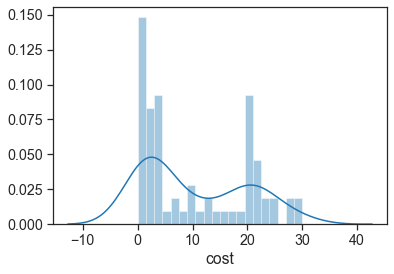

In [24]:
sns.distplot(df.cost, bins=20)

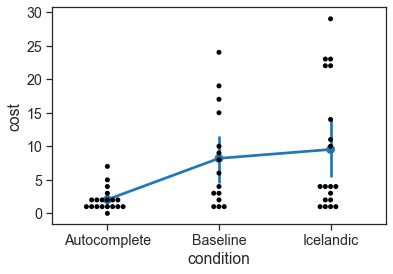

In [79]:
cond_plot('cost', exclude=True)

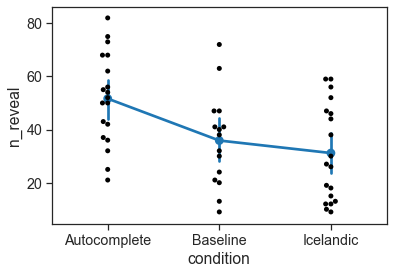

In [20]:
cond_plot('n_reveal', True)

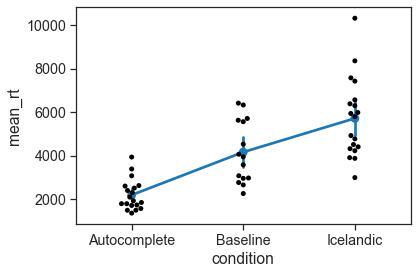

In [21]:
cond_plot('mean_rt', True)

# Likelihood breakdown

In [4]:
models = "Optimal BestFirst MetaGreedy BiasedOptimal BiasedBestFirst BiasedMetaGreedy".split()
models = "BestFirst Optimal MetaGreedy BiasedBestFirst BiasedOptimal BiasedMetaGreedy".split()

paired = sns.palettes.color_palette('Paired')
pal = dict(zip(models, [*paired[1:7:2], *paired[0:6:2]]))

In [5]:
df = pd.read_csv('julia/real_results/likelihoods.csv')
df['full_model'] = df.biased.apply(lambda x: 'Biased' if x else '') + df.model

no_click = df.query('full_model == "Optimal"').groupby(['map', 'wid']).apply(len) < 2
usually_click = no_click.groupby('wid').sum() <= 2
print(usually_click.mean())
df = df.set_index('wid').loc[usually_click]
len(df.reset_index().wid.unique())

0.5833333333333334


42

In [9]:
d = df.set_index('full_model').logp
diff = d['BiasedOptimal'] - d['BiasedBestFirst']

In [10]:
stim = df.groupby(['full_model', 'map']).logp.sum()
diff = stim['BiasedOptimal'] - stim['BiasedBestFirst']
diff

map
fantasy_map_1560976725599.png    100.928287
fantasy_map_1560976804519.png     -9.640754
fantasy_map_1560976821363.png     15.589968
fantasy_map_1560976853546.png     15.070749
fantasy_map_1560976873961.png      3.251478
fantasy_map_1560976890783.png     17.408780
fantasy_map_1560976900330.png     20.198196
fantasy_map_1560977229084.png     15.917673
Name: logp, dtype: float64

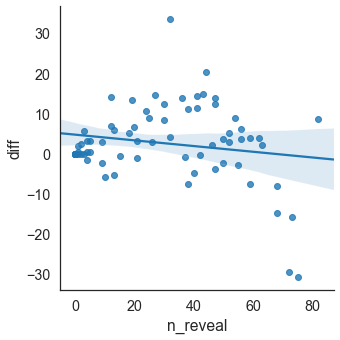

In [337]:
d = ind.set_index(['full_model', 'wid']).logp
diff = d['BiasedOptimal'] - d['BiasedBestFirst']
data = pdf.set_index('wid')[['logp', 'n_reveal', 'cost']]
data['diff'] = diff
sns.lmplot('n_reveal', 'diff', data=data)

In [12]:
ind = df.groupby(['full_model', 'wid']).logp.sum().reset_index()
n_obs = df.groupby('wid').apply(len) / len(models)
ind['avg_logp'] = list(ind.set_index('wid').logp / n_obs)

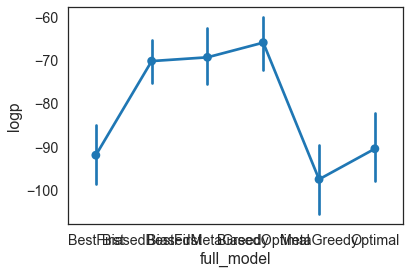

In [16]:
# sns.pointplot('full_model', 'logp', data=ind, )


In [20]:
val = 'logp'
avg = ind.set_index('full_model').loc[models].groupby('full_model')[val].mean()
plt.plot(avg.values, avg.index)

full_model
BestFirst          -91.950733
BiasedBestFirst    -70.255858
BiasedMetaGreedy   -69.388097
BiasedOptimal      -66.000516
MetaGreedy         -97.521456
Optimal            -90.470338
Name: logp, dtype: float64

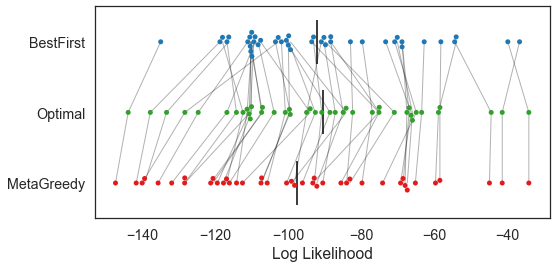

In [49]:
# horizontal orientation

def plot_line(models, d, val):
    plt.plot(models, d.set_index('full_model').loc[models][val], color='k', lw=1, alpha=0.3)

def plot_participants(val, models=models):
    plt.figure(figsize=(8,4))
    sns.swarmplot(y='full_model', x=val, data=ind, order=models, palette=pal, )
    for w, d in ind.groupby('wid'):
        plt.plot(d.set_index('full_model').loc[models][val], models, color='k', lw=1, alpha=0.3)
#     plt.plot(ind.set_index('full_model').loc[models][val])
    avg = ind.set_index('full_model').loc[models].groupby('full_model')[val].mean()
    plt.scatter(avg.values, avg.index, s=2000, marker='|', c='k')
    plt.ylabel('')
    plt.xlabel('Log Likelihood')

plot_participants('logp', models=models[:3])
plt.tight_layout()
plt.savefig('individual_likelihood_nobias.pdf')

In [44]:
alt_models = models[::3] + models[1::3] + models[2::3]

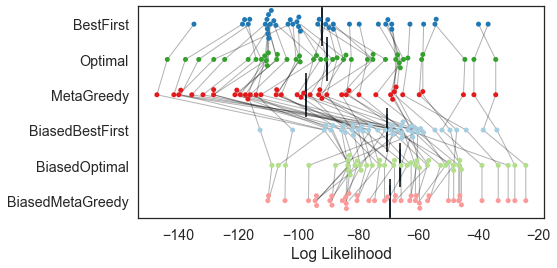

In [48]:
plot_participants('logp', models=models)
plt.tight_layout()
plt.savefig('individual_likelihood.pdf')

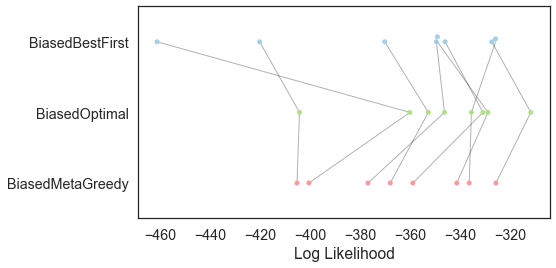

In [53]:
stim = df.groupby(['full_model', 'map']).logp.sum().reset_index()

def plot_participants(val, models=models):
    plt.figure(figsize=(8,4))
    sns.swarmplot(y='full_model', x=val, data=stim, order=models, palette=pal, )
    for w, d in stim.groupby('map'):
        plt.plot(d.set_index('full_model').loc[models][val], models, color='k', lw=1, alpha=0.3)
#     plt.plot(stim.set_index('full_model').loc[models][val])
#     avg = stim.set_index('full_model').loc[models].groupby('full_model')[val].mean()
#     plt.scatter(avg.values, avg.index, s=2000, marker='|', c='k')
    plt.ylabel('')
    plt.xlabel('Log Likelihood')
        
plot_participants('logp', models=models[3:])
plt.tight_layout()
plt.savefig('map_likelihood.pdf')

# Termination

In [12]:
df = pd.read_csv(f'model/results/{EXPERIMENT}/features.csv')
df.term_reward = df.term_reward.apply(int)

def get_agent(wid):
    return wid.split('-')[0] if '-' in wid else 'Human'

df['agent'] = df.wid.apply(get_agent)

In [32]:
def savefig(name):
    plt.tight_layout()
    plt.savefig(f'figs/{name}.png', dpi=300)

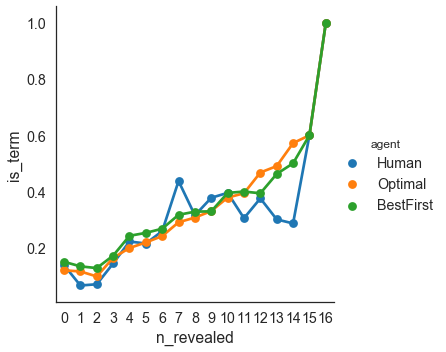

In [21]:
sns.catplot('n_revealed', 'is_term', data=df, kind='point', hue='agent', ci=False)
savefig('term_revealed')

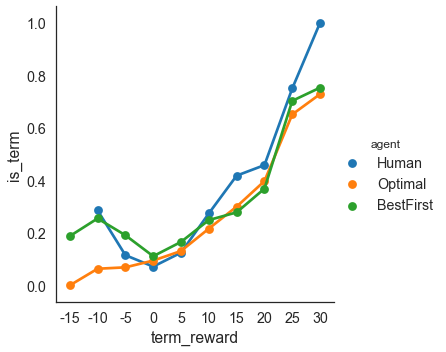

In [25]:
sns.catplot('term_reward', 'is_term', data=df, kind='point', hue='agent', ci=False)
savefig('term_reward')

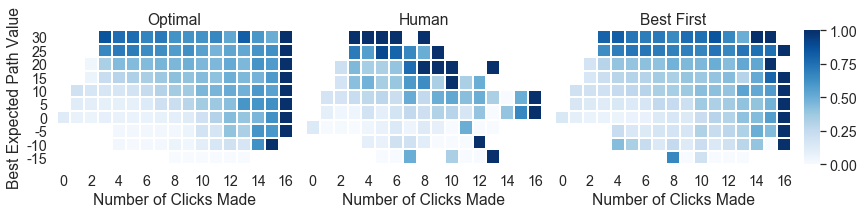

In [33]:
# x = df.groupby(['etr', 'n_revealed']).is_term.mean().reset_index()
def robust_mean(x):
    return np.mean(x)
    if len(x) < 5:
        return np.nan
    return np.mean(x)

# lims = {''}

def plot_adaptive(df, **kws):
    X = df.groupby(['term_reward', 'n_revealed']).is_term.apply(robust_mean).unstack()
    # X = df.groupby(['etr', 'n_revealed']).apply(len).unstack()
    sns.heatmap(X, cmap='Blues', linewidths=1, **kws).invert_yaxis()
    plt.xlabel('Number of Clicks Made')
#     plt.ylim(*lims['y'])
#     plt.xlim(*lims['x'])

    
fig, axes = plt.subplots(1, 4, figsize=(12, 3),
                         gridspec_kw={'width_ratios': [15, 15, 15, 1]})

# fig, axes = plt.subplots(1, 2, figsize=(8,4))

plt.sca(axes[0])
plot_adaptive(df.query('agent == "Optimal"'), cbar_ax=axes[3])
plt.ylabel("Best Expected Path Value")
plt.title("Optimal")

plt.sca(axes[1])
plot_adaptive(df.query('agent == "Human"'), cbar=False)
plt.title("Human")
plt.ylabel("")
plt.yticks(())

plt.sca(axes[2])
plot_adaptive(df.query('agent == "BestFirst"'), cbar=False)
plt.title("Best First")
plt.ylabel("")
plt.yticks(())
savefig('adaptive_satisficing')

# Scratch

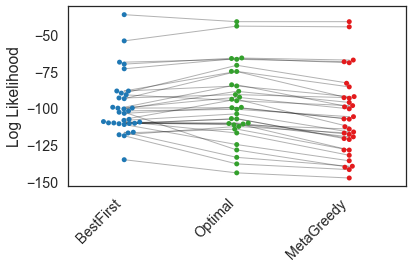

In [286]:
def plot_line(models, d, val):
    plt.plot(models, d.set_index('full_model').loc[models][val], color='k', lw=1, alpha=0.3)

def plot_participants(val, models=models):
    ax = sns.swarmplot('full_model', val, data=ind, order=models, palette=pal)
    for w, d in ind.groupby('wid'):
        plot_line(models, d, val)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.xlabel('')
    plt.ylabel('Log Likelihood')
#         plot_line(models[:3], d, val)
#         plot_line(models[3:], d, val)
        
plot_participants('logp', models=models[:3])
plt.tight_layout()
plt.savefig('individual_likelihood_nobias.pdf')

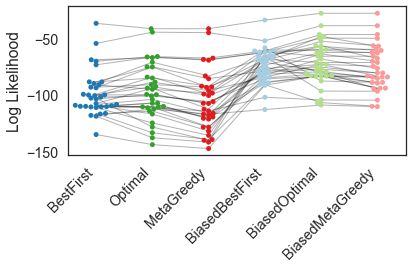

In [287]:
plot_participants('logp', models=models)
plt.tight_layout()
plt.savefig('individual_likelihood.pdf')

In [ ]:
import json
# EXPERIMENT = 'webofcash-pilot-1.1'
EXPERIMENT = 'webofcash-1.2'
def load_trials(experiment):
    with open(f'data/{experiment}/trials.json') as f:
        data = json.load(f)

    for wid, trials in data.items():
        for t in trials:
            t['wid'] = wid
            yield t
            
data = pd.DataFrame(load_trials(EXPERIMENT))
data['n_click'] = data.reveals.apply(len)
data['raw_reward'] = data.score + data.n_click  # assumes cost = 1
